In [59]:
import numpy as np

%matplotlib notebook

import matplotlib.pyplot as plt

In [60]:
import os
import lsst.daf.persistence as dafPersist
import lsst.pex.exceptions as pexExcept
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.display as afwDisplay
import lsst.afw.display.utils as dispUtils

In [61]:
butler = dafPersist.Butler(os.path.join("/gpfs01/wrk/yasuda/P9_2017", "rerun", "yasuda/rerun/all_clip"))

afwDisplay.setDefaultBackend("ds9" if False else "matplotlib")
afwDisplay.Display.delAllDisplays()

In [62]:
dataId = dict(tract=9741, patch='5,2', filter='HSC-G')
visit = 131564 if False else 131694

In [63]:
exp = butler.get("deepCoadd_calexp_hsc", dataId)
dsrc = butler.get("deepCoadd_tempExp_diffsrc", dataId, visit=visit)
dexp = butler.get("deepCoadd_tempExp_diff", dataId, visit=visit)

<IPython.core.display.Javascript object>


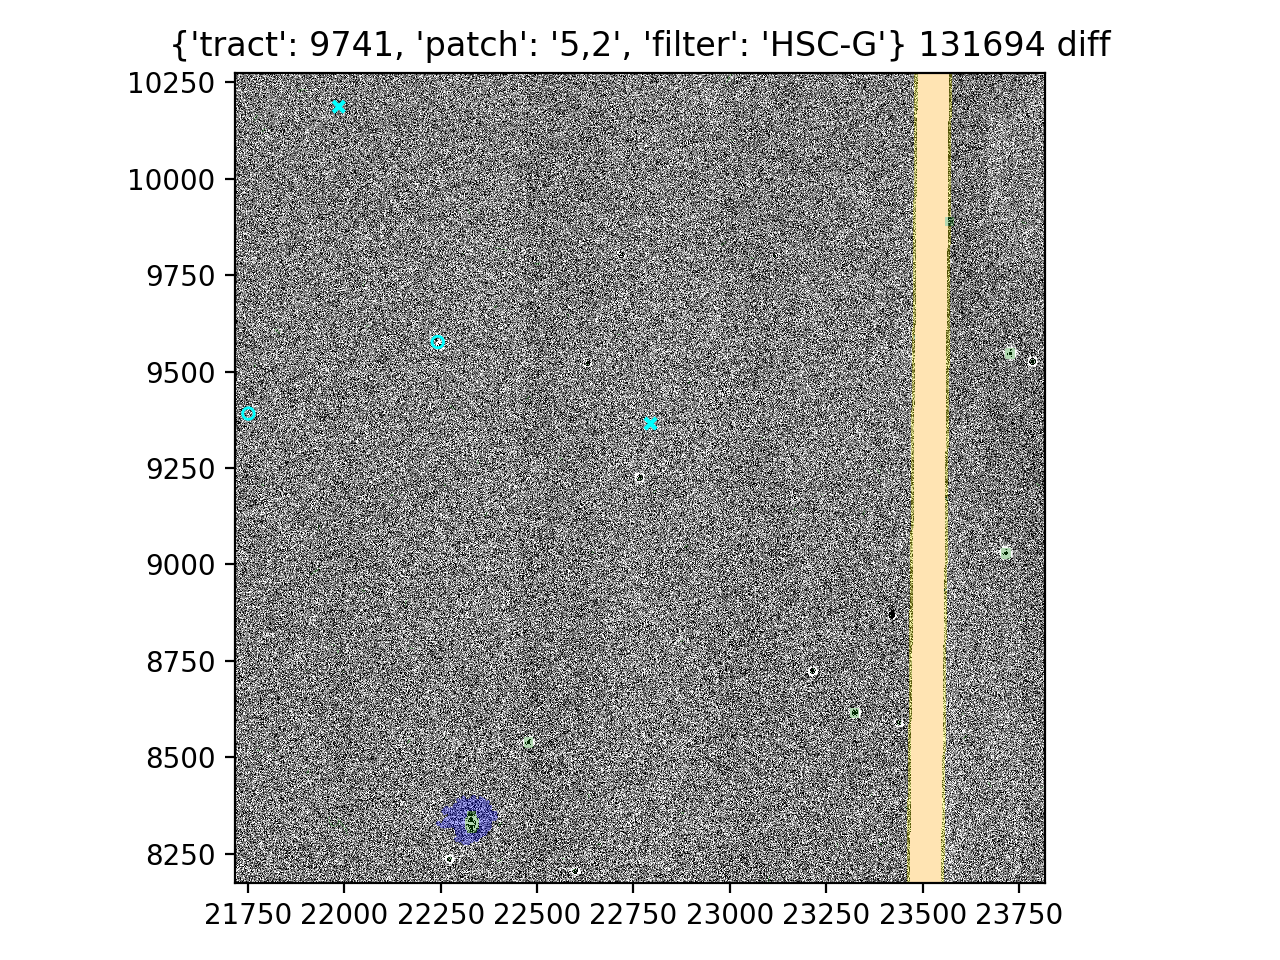

In [76]:
disp = afwDisplay.Display(0)

#disp.scale('asinh', 'zscale')
disp.scale('linear', -10, 10)
disp.setMaskPlaneColor("DETECTED", afwDisplay.IGNORE)
disp.mtv(dexp, title="%s %d diff" % (dataId, visit))

In [77]:
def plotSrcs(src, disp, exp=None):
    with disp.Buffering():
        for s in src:
            ctype = afwDisplay.CYAN
            
            if True:
                if s.get('sky'):
                    continue
                if s.get("flag_pixel_saturated_center") or s.get("flag_pixel_interpolated_center"):
                    continue
                if 5*1.44*s.getPsfFluxErr() > np.abs(s.getPsfFlux()):
                    continue
                    
            # Yasuda's cuts
            if s.get("residual") > 7 or s.get("significance") < 5 or not (0.8 < s.get("elongation_norm") < 1.2):
                continue
            
            if exp is not None:
                try:
                    x, y = [int(_) for _ in s.getCentroid() - dexp.getXY0()]
                except ValueError:
                    continue

                if exp.mask.get(x, y) & exp.mask.getPlaneBitMask(["INTRP", "SAT"]):
                    #print(s.get("flag_pixel_saturated_center"), s.get("flag_pixel_interpolated_center"))
                    ctype = afwDisplay.MAGENTA
                    continue
        
            size = 15
            symb = 'o' if s.get("classification_extendedness") > 0 else 'x'
            ctype = 'red' if s.get('sky') else ctype
            disp.dot(symb, *s.getCentroid(), ctype=ctype, size=size)

In [81]:
disp.erase()
zoom, x, y = 4, 23774, 9538
x, y = 2867 + dexp.getX0(), 1325 + dexp.getY0()
disp.zoom(zoom, x, y)

plotSrcs(dsrc, disp, dexp)

<IPython.core.display.Javascript object>


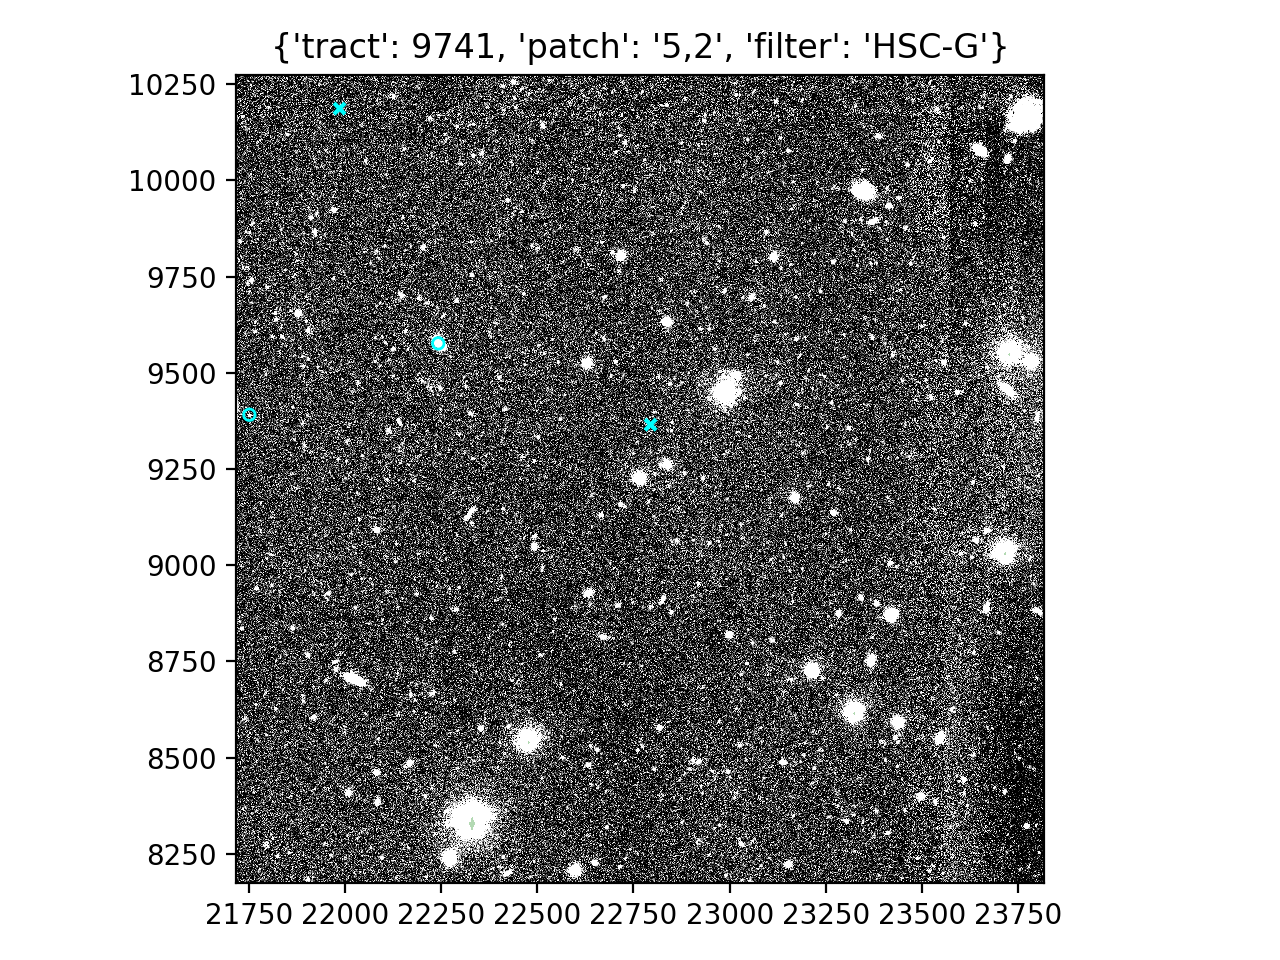

In [82]:
disp1 = afwDisplay.Display(1)
disp1.setMaskPlaneColor("DETECTED", afwDisplay.IGNORE)

#disp1.scale('asinh', 'zscale')
disp1.scale('linear', -0.01, .1)
disp1.mtv(exp, title=dataId)
disp1.zoom(zoom, x, y)
#disp1.dot('o', x, y, size=15)
plotSrcs(dsrc, disp1, dexp)

<IPython.core.display.Javascript object>


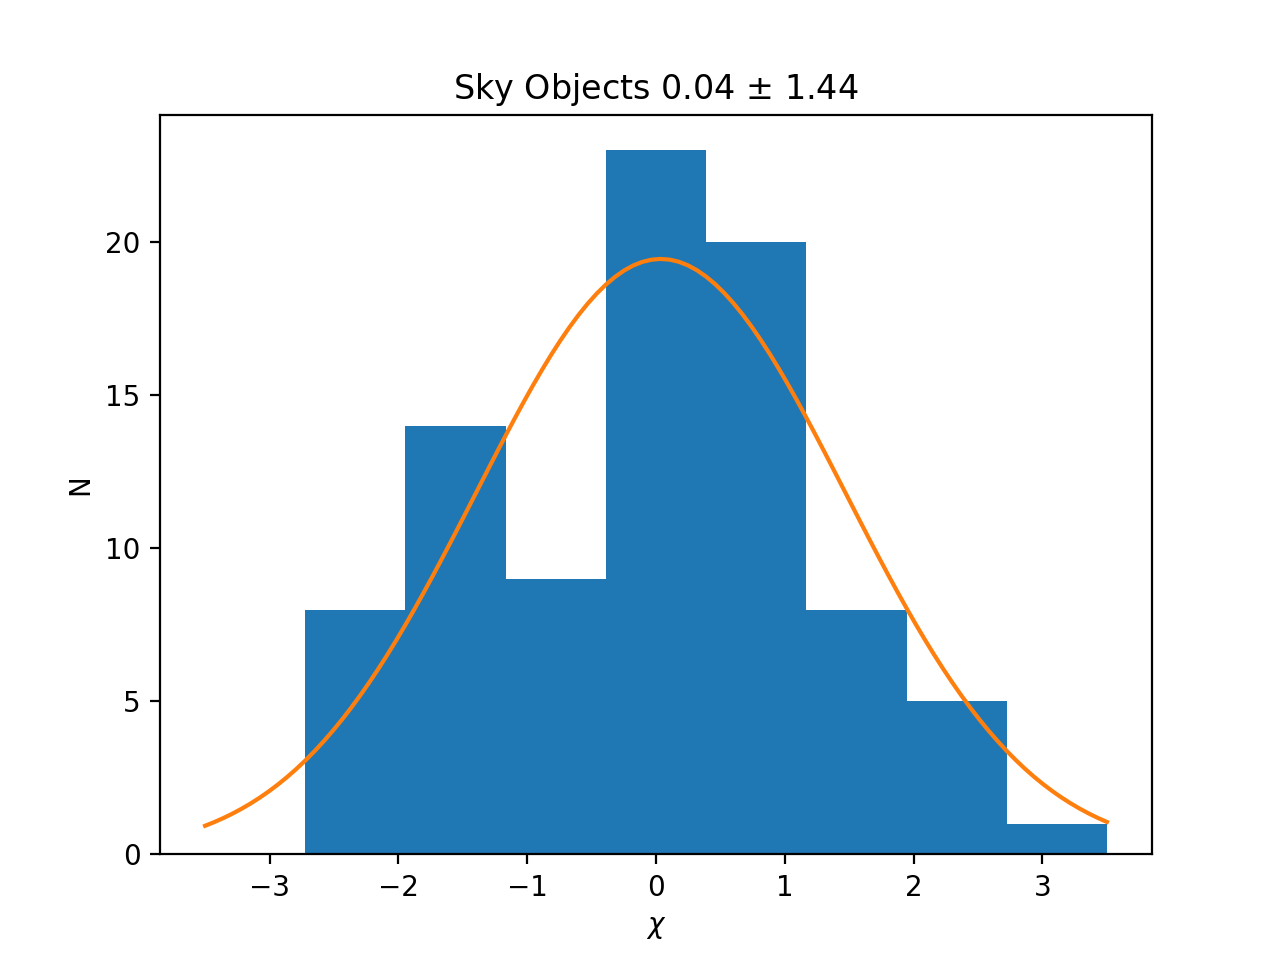

In [88]:
#
# Estimate how underestimated the photometric errors are
#
fig = plt.figure()

isSky = np.logical_and(dsrc.get("sky") == 1, np.isfinite(dsrc.getPsfFlux()))
psfFlux = dsrc.getPsfFlux()[isSky]
psfFluxErr = dsrc.getPsfFluxErr()[isSky]

chi = psfFlux/psfFluxErr
mean, std = np.mean(chi), np.std(chi)

bins = np.linspace(-3.5, 3.5, 10)
plt.hist(chi, bins=bins)

x = np.linspace(bins[0], bins[-1], 100)
plt.plot(x, len(chi)*(bins[1] - bins[0])/np.sqrt(2*np.pi*std**2)*np.exp(-0.5*((x - mean)/std)**2))

plt.xlabel(r"$\chi$")
plt.ylabel("N")
plt.title(r"Sky Objects %.2f $\pm$ %.2f" % (mean, std));

In [89]:
def findSource(srcs, ra, dec):
    ids = srcs.get('id')
    d = np.hypot(np.degrees(srcs.get("coord_ra")) - ra, np.degrees(srcs.get("coord_dec")) - dec)
    good = np.isfinite(d)

    return list(iter(srcs[ids == ids[good][np.argmin(d[good])]]))[0]  # convert record back to source.  Ughhh

In [90]:
ra, dec = 42.95398, 1.9084  # ghost?
#ra, dec = 42.95418, 1.8901 # bright star
#ra, dec = 42.95425, 1.8902  # junk near bright star 3 epochs
ra, dec = 42.88739, 1.8054  # variable.  Note possible brighter-fatter in direct subtractions.
#ra, dec = 43.01944, 1.8421  # junk
#ra, dec = 42.89917, 1.8196  # constant
#ra, dec = 42.92017, 1.8490  # faint false
#ra, dec = 42.86904, 1.7958
#ra, dec = 42.97110, 1.8467   # -ve in all 4 difference images ?!*!
#ra, dec = 42.91796, 1.8219
ra, dec = 42.95746, 1.90198
ra, dec = 43.02803, 1.83464
s = findSource(dsrc, ra, dec)

disp.pan(*s.getCentroid())
disp1.pan(*s.getCentroid())

<IPython.core.display.Javascript object>


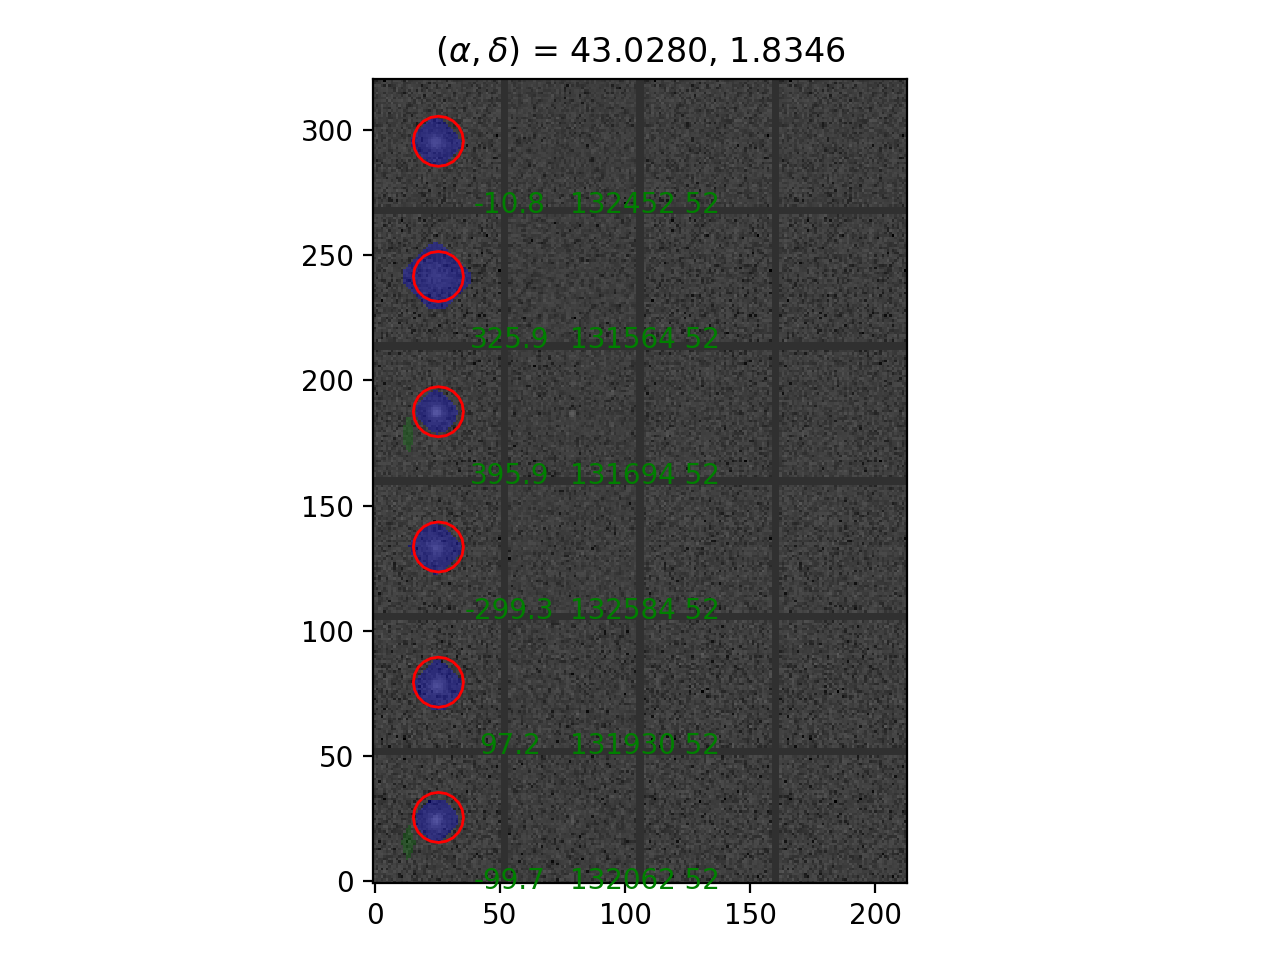

In [91]:
disp2 = afwDisplay.Display(2, "matplotlib")

cinfo = exp.getInfo().getCoaddInputs()

mos = dispUtils.Mosaic(background=-10, mode='x')
size = 51
hsize = afwGeom.ExtentI(size//2, size//2)

calexpSources = []
for ci in cinfo.ccds.subsetContaining(s.getCoord()):
    ccdDataId = dict(visit=ci.get("visit"), ccd=ci.get("ccd"))
    wcs = butler.get("calexp_wcs", ccdDataId)
    calib = butler.get("calexp_calib", ccdDataId)
    #
    # The image in the single epoch data
    #
    pos = afwGeom.PointI(wcs.skyToPixel(s.getCoord()))
    bbox = afwGeom.BoxI(pos - hsize, pos + hsize)
    im = butler.get("calexp_sub", ccdDataId, bbox=bbox)
        
    ss = findSource(butler.get("src", ccdDataId), ra, dec)  # single-visit direct image source
    calexpSources.append((ss, calib))

    mos.append(im.maskedImage)
    #
    # the single epoch difference image
    #
    pos = afwGeom.PointI(s.getCentroid())
    bbox = afwGeom.BoxI(pos - hsize, pos + hsize)
    dim = butler.get("deepCoadd_tempExp_diff_sub", dataId, visit=ccdDataId['visit'], bbox=bbox)
    dim.mask[:] = 0
    #
    # Find aperture flux
    #
    apRad = 15
    ima = dim.image.array
    X = np.arange(-25, 26)
    X, Y = np.meshgrid(X, X)
    ap = np.hypot(X, Y) < apRad
    apFlux = np.sum(ima[ap] - np.mean(ima[ap == False]))
    #ima[ap == False] = 0
    mos.append(dim.maskedImage, label="%.1f" % apFlux)

    #
    # the direct subtraction at the position of the coadd source
    #
    psf = im.getPsf()
    pos = ss.getCentroid()                # the measured centroid of the nearest source
    psfIm = afwImage.makeMaskedImage(psf.computeImage(pos).convertF())
    psfIm *= ss.getPsfFlux()/ss.get('flux_psf_apcorr')
    
    ddim = im.maskedImage.clone()
    try:
        ddim[psfIm.getBBox(), afwImage.PARENT] -= psfIm
    except pexExcept.LengthError as e:
        ddim.image[:] = 0
    ddim.mask[:] = 0

    mos.append(ddim, label="%d %d" % (ccdDataId['visit'], ccdDataId['ccd']))

    #
    # and the direct subtraction at the position of the difference source
    #
    psf = im.getPsf()
    pos = ss.getCentroid()                # the measured centroid of the nearest source
    diffimPos = wcs.skyToPixel(s.getCoord()) # the centroid where the object's expected from the diffim
    if False:
        print(r"delta = %.0fmas" % (168*(pos - diffimPos).computeNorm()))
    if (pos - diffimPos).computeNorm() > 2:   # if the nearest source isn't close, don't use it!
        pos = diffimPos
    psfIm = afwImage.makeMaskedImage(psf.computeImage(pos).convertF())
    psfIm *= ss.getPsfFlux()/ss.get('flux_psf_apcorr')
    
    ddim = im.maskedImage.clone()
    try:
        ddim[psfIm.getBBox(), afwImage.PARENT] -= psfIm
    except pexExcept.LengthError as e:
        ddim.image[:] = 0
        if False:   # debugging
            print(e, ss.getCentroid(), ss.getPsfFlux(), psfIm.getBBox())
            disp3 = afwDisplay.Display(3)
            if True:
                calexp = butler.get("calexp", ccdDataId)
                disp3.mtv(calexp)
                xy0 = calexp.getXY0()
            disp3.erase()
            dispUtils.drawBBox(ddim.getBBox(), display=disp3, ctype=afwDisplay.GREEN, origin=xy0)
            dispUtils.drawBBox(psfIm.getBBox(), display=disp3, ctype=afwDisplay.RED, origin=xy0)

            disp3.pan(*ss.getCentroid())

            break

    ddim.mask[:] = 0

    mos.append(ddim)

disp2.scale('asinh', 'zscale')
nCol = 4
mos.makeMosaic(display=disp2, mode=nCol,
               title=r"$(\alpha, \delta)$ = %.4f, %.4f" % (ra, dec))

showCenter = not False
if showCenter:
    for i in range(mos.ny):
        bbox = mos.getBBox(0, i)
        disp2.dot('o', *(bbox.getBegin() + 0.5*bbox.getDimensions()), ctype=afwDisplay.RED, size=10)

<IPython.core.display.Javascript object>


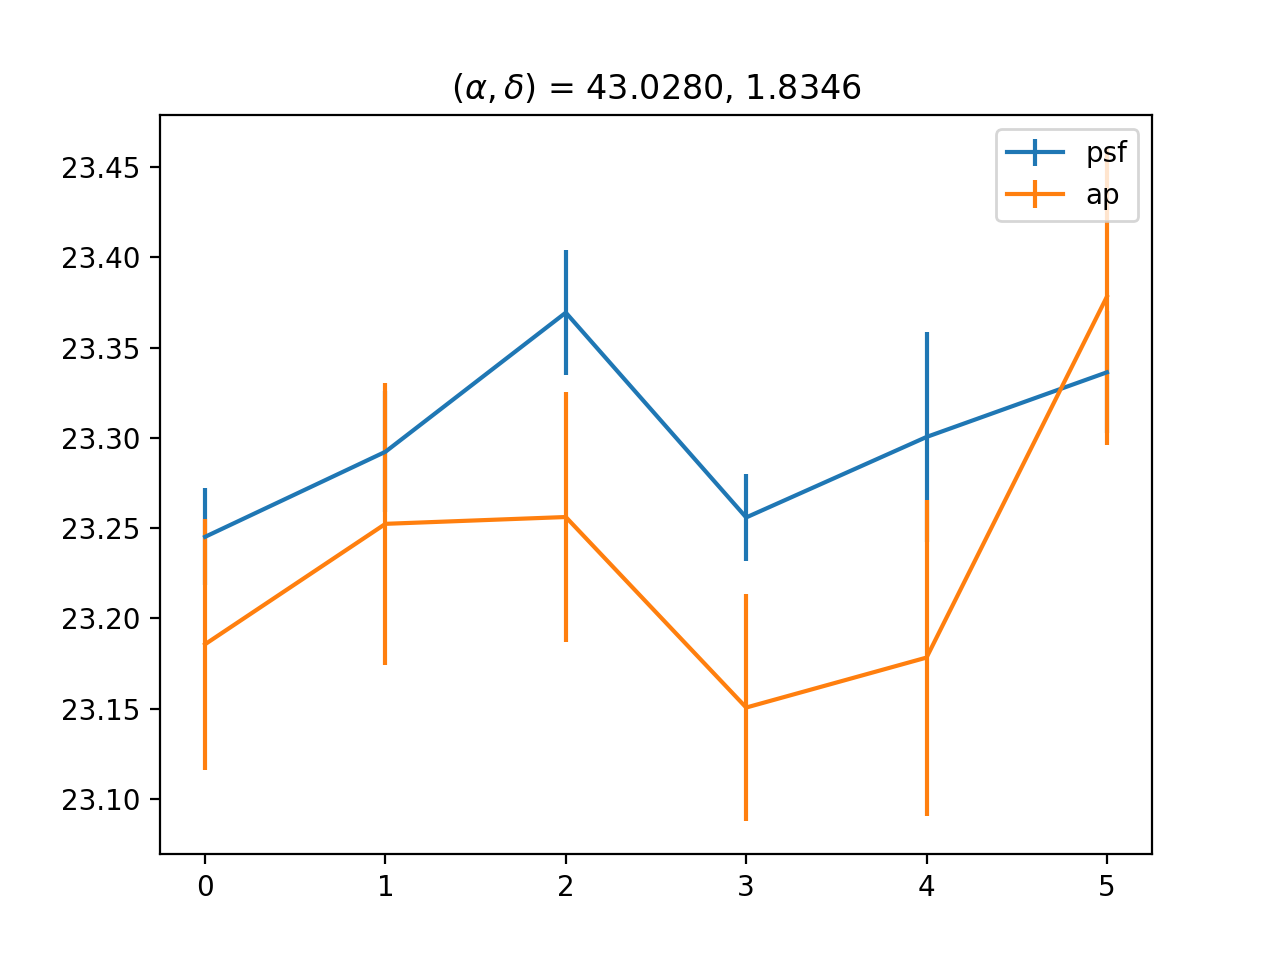

In [92]:
flux = [_.getPsfFlux() for _, _c in calexpSources]
fluxErr = [_.getPsfFluxErr() for _, _c in calexpSources]

psfMag    = np.empty(len(calexpSources))
psfMagErr = np.empty_like(psfMag)
apMag     = np.empty_like(psfMag)
apMagErr  = np.empty_like(psfMag)

for i, (ss, calib) in enumerate(calexpSources):
    psfMag[i], psfMagErr[i] = calib.getMagnitude(ss.getPsfFlux(), ss.getPsfFluxErr())
    psfMagErr[i] = ss.getPsfFluxErr()/ss.getPsfFlux()

    apMag[i], apMagErr[i] = calib.getMagnitude(ss.getApFlux(), ss.getApFluxErr())
    apMagErr[i] = ss.getApFluxErr()/ss.getApFlux()

plt.errorbar(np.arange(len(psfMagErr)), psfMag, yerr=psfMagErr, label='psf')
plt.errorbar(np.arange(len(apMagErr)),  apMag,  yerr=apMagErr,  label='ap')
plt.legend(loc='best')

yrange = 0.1
ylim = plt.ylim()
if ylim[1] - ylim[0] < yrange:
    plt.ylim(np.mean(ylim) + 0.5*yrange*np.linspace(1, -1, 2))

plt.title(r"$(\alpha, \delta)$ = %.4f, %.4f" % (ra, dec));

In [93]:
cis = cinfo.ccds.subsetContaining(s.getCoord())
visits = []
_xSlices = []
for ci in cis:
    ccdDataId = dict(visit=ci.get("visit"), ccd=ci.get("ccd"))
    wcs = butler.get("calexp_wcs", ccdDataId)

    pos = afwGeom.PointI(wcs.skyToPixel(s.getCoord()))
    bbox = afwGeom.BoxI(pos - hsize, pos + hsize)
    psf = butler.get("calexp_sub", ccdDataId, bbox=bbox).getPsf()
        
    ss = findSource(butler.get("src", ccdDataId), ra, dec)  # single-visit direct image source
    #
    pos = ss.getCentroid()                # the measured centroid of the nearest source
    psfIm = afwImage.makeMaskedImage(psf.computeImage(afwGeom.PointD(int(ss.getX()), int(ss.getY()))).convertF())
    
    visits.append(ccdDataId["visit"])
    _xSlices.append(psfIm[:, psfIm.getWidth()//2].image.array[0])
    
xSlices = np.empty((len(_xSlices), len(_xSlices[0])))
for i, xSlice in enumerate(_xSlices):
    xSlices[i] = xSlice
del _xSlices
 

<IPython.core.display.Javascript object>


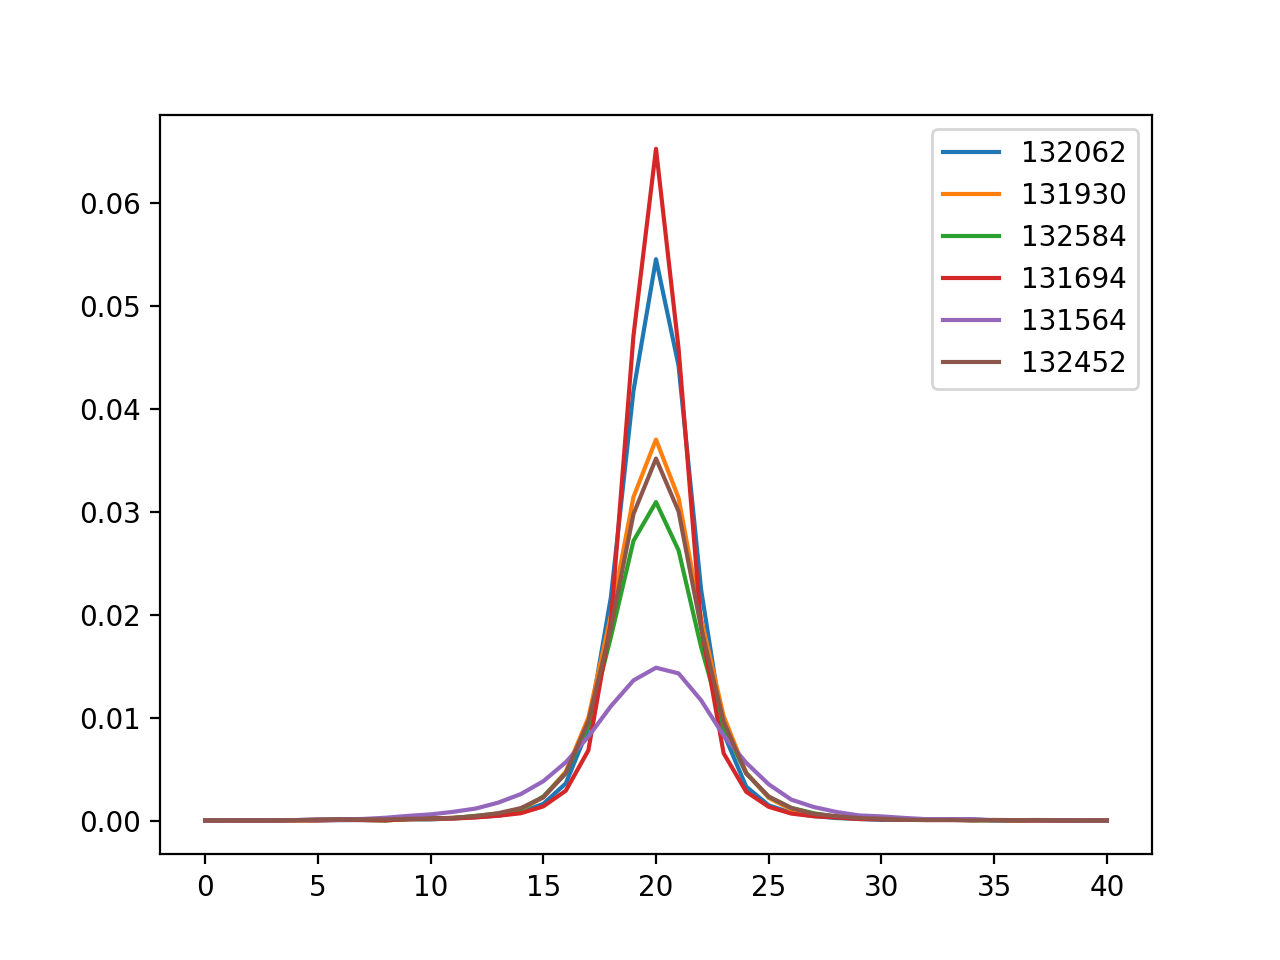

In [95]:
for v, xSlice in zip(visits, xSlices):
    plt.plot(xSlice, label=v)

if False:   # show quartiles
    q25, q50, q75 = np.percentile(xSlices, [25, 50, 75], axis=0)
    std = 0.741*(q75 - q25)
    plt.plot(q50 - std, ls=':', label='q - 1')
    plt.plot(q50, ls=':', label='median')
    plt.plot(q50 + std, ls=':', label='q + 1')

plt.legend(loc='best');